In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
from scipy.stats import gaussian_kde

## set default matplotlib font and font size
typeface='Helvetica Neue'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

import imp,os
from itertools import permutations

bt=imp.load_source('baltic_bacter','/Users/evogytis/Documents/baltic/baltic_bacter.py')

h3n2.HA_NA.summary.trees


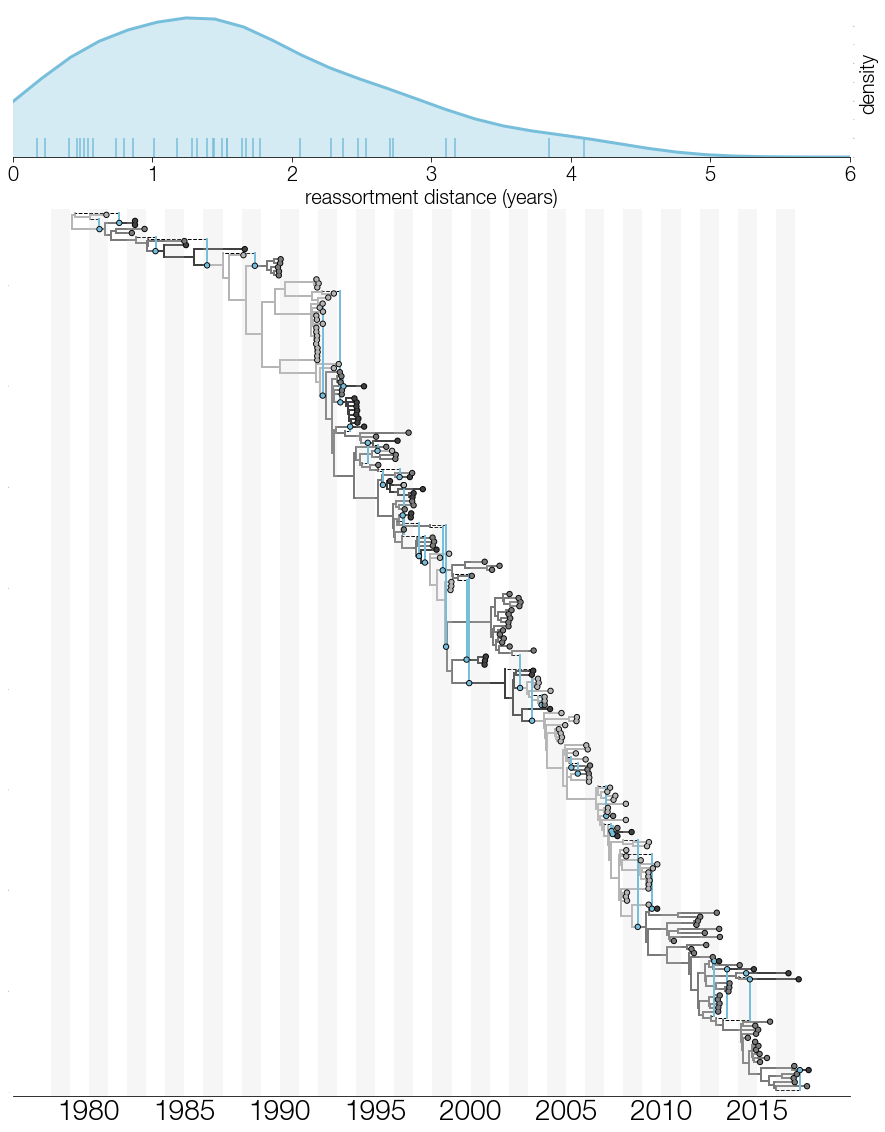

In [2]:
segments=['PB2','PB1','PA','HA','NP','NA','MP','NS']
translate={i:segments.index(x) for i,x in enumerate(sorted(segments))}

colourSwitches=[mpl.cm.Greys(i) for i in np.linspace(0.4,0.8,3)]

colours={'PB1':(0.2981622478541206, 0.44644367598435458, 0.64719724652229571),
        'PB2':(0.28098424626331703, 0.63955403192370541, 0.39507882933990629),
        'PA':(0.8162552973803352, 0.41062668737243202, 0.29078047883276847),
        'HA':(0.88366013765335083, 0.77908497055371606, 0.18562091886997223),
        'NP':(0.8, 0.4745098039215686, 0.6549019607843137),
        'NA':(0.4666666666666667, 0.7450980392156863, 0.8588235294117647),
        'MP':(0.49803923567136127, 0.43267975250879925, 0.52287583549817396),
        'NS':(0.8, 0.7552941176470589, 0.5929411764705883)}


path='/Users/evogytis/Documents/Reassortment-Material/Applications/H3N2/combined/'
fname='h3n2.HA_NA.summary.trees'

tree_path=os.path.join(path,fname)
print(fname)

ll=bt.loadNexus(tree_path,date_fmt='%Y-%m-%d',verbose=False) ## load tree
ll.drawTree()

fig = plt.figure(figsize=(15, 20),facecolor='w') ## new figure
# gs = gridspec.GridSpec(2,2,height_ratios=[1,4],width_ratios=[1,4],wspace=0.1,hspace=0.1) 
gs = gridspec.GridSpec(2,2,height_ratios=[1,6],width_ratios=[1,4],wspace=0.2,hspace=0.1) 

ax=plt.subplot(gs[1,0:],facecolor='w') ## first subplot - tree

# for i in range(len(colours)):
#     seg=segments[i]
#     ax.text(0.05,0.75-i/23.0,seg,size=42,color=colours[seg],transform=ax.transAxes,fontdict={'family':'Arial'}) ## plot segment colour legend

posteriorCutoff=lambda k: k.traits['posterior']>0.0 ## define cutoff for removing reassortment events

keep=set(list(filter(posteriorCutoff,ll.getBranches(lambda k: isinstance(k,bt.reticulation))))+ll.getExternal(lambda k: isinstance(k,bt.leaf))) ## remove reassortment at a given cutoff

ll=ll.reduceTree(keep) ## reduce tree down to those that pass posterior cutoff

for k in ll.Objects:
    k.traits['re']=0

for k in sorted(ll.Objects,key=lambda w: w.height): ## iterate through branches, starting with oldest ones
    if hasattr(k,'contribution'): ## if branch is the result of reassortment
        subtree=ll.traverse_tree(k.children[-1],include_condition=lambda w:True) ## traverse the subtree, remembering every branch visited along the way
        for w in subtree: ## for every branch in subtree
            if posteriorCutoff(k.contribution): ## if it's a branch that passes a posterior threshold
                w.traits['re']=max([w.traits['re']+1,k.contribution.traits['re']+1]) ## increment on maximum reassortment number up to this point (increment either parent's or contribution's statistic)

for k in ll.Objects: ## iterate over branches
    x=k.absoluteTime
    xp=k.parent.absoluteTime
    y=k.y

    col=colourSwitches[k.traits['re']%len(colourSwitches)] ## colour cycles through range defined at the beginning
#     mostReassortments=max([w.traits['re'] for w in ll.Objects if 're' in w.traits])
#     norm=mpl.colors.Normalize(-mostReassortments/3,mostReassortments)
#     col=mpl.cm.Greys(norm(k.traits['re']))
#                 print(col)

    if isinstance(k,bt.reticulation)==False: ## if a regular branch - colour based on number of reassortments from root
        ax.plot([x,xp],[y,y],color=col,lw=2,zorder=0)
    else:
        ax.plot([x,xp],[y,y],color='k',lw=1,ls='--',zorder=0) ## reassortment branches are black

    if k.branchType=='node': ## if node - plot vertical bar
        left,right=k.children[-1].y,k.children[0].y
        ax.plot([x,x],[left,right],color=col,lw=2,zorder=0)
    elif isinstance(k,bt.leaf): ## if actual leaf - add circle
        ax.scatter(x,y,s=20,facecolor=col,edgecolor='none',zorder=4)
        ax.scatter(x,y,s=40,facecolor='k',edgecolor='none',zorder=3)

    elif isinstance(k,bt.reticulation): ## dealing with reassortant branch
        if posteriorCutoff(k): ## passes posterior threshold
            segs=sorted(map(int,k.traits['segments'])) ## get travelling segment(s)

            c='k'
            s=20
            for i in range(len(segs)):
                name=segments[translate[segs[i]]] ## get name of segment
                c=colours[name] ## get appropriate colour
                o=1/20.

                ax.plot([x+o*i,x+o*i],[y,k.target.y],color=c,lw=2,ls='-',zorder=1) ## plot vertical lineage leaving donor and heading to recipient
                ax.scatter(x+o*i,k.target.y,s=s,facecolor=c,edgecolor='none',zorder=3) ## plot circles
                ax.scatter(x+o*i,k.target.y,s=s*2,facecolor='k',edgecolor='none',zorder=2)

[ax.spines[loc].set_visible(False) for loc in ax.spines if loc!='bottom'] ## remove axis spines
# [ax.axvline(i,ls='-',color='lightgrey',lw=1,alpha=0.2) for i in range(int(ll.root.absoluteTime-1),int(ll.root.absoluteTime+ll.treeHeight+1),1)] ## add timeline
timewidth=1
[ax.axvspan(i,i+timewidth,facecolor='lightgrey',edgecolor='none',alpha=0.2) for i in range(int(ll.root.absoluteTime-1),int(ll.root.absoluteTime+ll.treeHeight+1),2*timewidth)] ## add timeline

ax.tick_params(axis='y',size=0,labelsize=0)
ax.tick_params(axis='x',size=0,labelsize=28)
ax.set_ylim(-1,ll.ySpan+1)


#### secondary plot - co-reassortment matrix
# ax1=plt.subplot(gs[0,0],facecolor='w')
# ax1.xaxis.tick_top()

# matrix=np.zeros((len(segments),len(segments))) ## empty matrix

# for k in ll.Objects: ## iterate over branches
#     if isinstance(k,bt.reticulation): ## branch is reassortant
#         travelling=[translate[s] for s in map(int,k.traits['segments'])] ## get travelling segments
#         if len(travelling)==1: ## if one - add count when it was the sole reassorting segment
#             sole=travelling[-1]
#             matrix[sole][sole]+=1
#         for combo in permutations(travelling,2): ## if there's more than one - add score to every pair of co-reassorting segments
#             i,j=combo
#             matrix[i][j]+=1

# for i in range(len(matrix)):
#     for j in range(len(matrix[i])):
#         ax1.text(i,j,int(matrix[i][j]),ha='center',va='center',color='k' if matrix[i][j]>2 else 'w',size=12,zorder=100) ## annotate matrix in plot

# ax1.imshow(matrix,cmap=mpl.cm.cividis) ## plot matrix
# ax1.set_xticks(range(len(segments)))
# ax1.set_xticklabels(segments,rotation=90)
# ax1.set_yticks(range(len(segments)))
# ax1.set_yticklabels(segments,rotation=0)
# ax1.tick_params(size=0,labelsize=20)
# for x in ax1.get_xticklabels():
#     x.set_color(colours[x.get_text()])
# for x in ax1.get_yticklabels():
#     x.set_color(colours[x.get_text()])
# ax1.set_xlabel('co-reassortment\nfrequency')


### tertiary plot - reassortment distance distribution
ax2=plt.subplot(gs[0,0:],facecolor='w')
# ax2=plt.subplot(gs[0,1],facecolor='w')
ax2.yaxis.tick_right()

re_distances=list(map(lambda k: k.height-ll.commonAncestor([k,k.target]).height,ll.getBranches(lambda k: isinstance(k,bt.reticulation)))) ## compute difference between reassortant node height and height of common ancestor of its parents (=reassortment distance)

x_grid=np.linspace(0,6,30)
ax2.plot(x_grid,gaussian_kde(re_distances).evaluate(x_grid),lw=3,color=colours['NA']) ## plot kernel density estimate
ax2.fill_between(x_grid,gaussian_kde(re_distances).evaluate(x_grid),lw=3,facecolor=colours['NA'],edgecolor='none',alpha=0.3) ## plot kernel density estimate
ax2.eventplot(re_distances,lineoffsets=[0],linelengths=[0.1],color=colours['NA']) ## plot every reassortment distance

[ax2.spines[loc].set_visible(False) for loc in ax.spines if loc!='bottom'] ## remove axis spines
ax2.set_xlabel('reassortment distance (years)',size=20)
ax2.set_ylabel('density',size=20)
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='x',size=5,labelsize=20)
ax2.tick_params(axis='y',size=0,labelsize=0)
ax2.set_ylim(bottom=0.0)
ax2.set_xlim(0,6)

plt.show()